In [21]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import skimage as sk
import random

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)

to_numpy = lambda x: x.detach().cpu().numpy()

cuda:1


Files already downloaded and verified


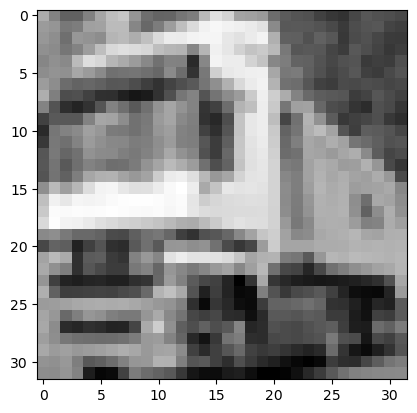

In [22]:
cifar = torchvision.datasets.CIFAR10(download=True, root='.')
cifar = cifar.data.transpose((0, 3, 1 ,2)).mean(1, keepdims=True)
# cifar = (cifar - cifar.mean((0, 2, 3), keepdims=True)) / (cifar.std((0, 2, 3), keepdims=True))
plt.imshow(cifar[1, 0], cmap='gray')

In [23]:
cifar_small = sk.transform.rescale(cifar, 0.5)
cifar_mini = sk.transform.rescale(cifar, 0.25)

(89400, 1, 16, 16)
(89400, 5)
[1. 0. 0. 0. 0.]


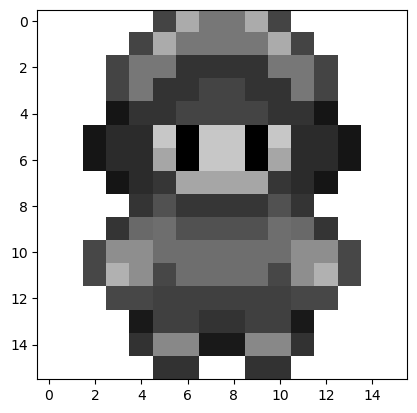

In [24]:
sprites = np.load('sprites.npy')
sprites = np.transpose(sprites, (0, 3, 1, 2)).mean(axis=1, keepdims=True)
sprite_labels = np.load('sprites_labels.npy')
print(sprites.shape)
print(sprite_labels.shape)
plt.imshow(sprites[0, 0], cmap='gray')
print(sprite_labels[0])

In [25]:
class PatchEmbed(nn.Module):
    def __init__(self, image_size=16, patch_size=2, in_chans=1, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.grid_h = image_size // patch_size
        self.grid_w = image_size // patch_size
        self.h_embed = nn.Parameter(torch.randn(1, embed_dim, self.grid_h, 1))
        self.w_embed = nn.Parameter(torch.randn(1, embed_dim, 1, self.grid_w))

    def forward(self, x):
        x = self.proj(x)  # [B, D, H/patch, W/patch]
        x = x + self.h_embed + self.w_embed
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, D]
        return x

In [28]:
class SimpleViT(nn.Module):
    def __init__(self, image_size=16, patch_size=2, embed_dim=256, num_layers=4, nhead=4):
        super().__init__()
        self.patch_embed = PatchEmbed(image_size=image_size, embed_dim=embed_dim, patch_size=patch_size)
        encoder = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder, num_layers=num_layers)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        patches = self.patch_embed(x)  # [B*T, P, D]
        # patches = patches.view(B, T, -1, patches.shape[-1])  # [B, T, P, D]
        # patches = patches.flatten(1, 2)  # [B, T*P, D]
        embeddings = self.transformer(patches)[:, -1, :]
        embeddings = embeddings.view(B, T, -1)
        return embeddings

In [ ]:
class VisionICLTransformer(nn.Module):
    def __init__(self, val_dim=1, embed_dim=256, num_heads=8, num_layers=12, vit_heads=2, vit_layers=4,
                 image_size=16, patch_size=4, max_seq_len=128):
        # max_seq_len corresponds to 2k, so k x_k samples and k f(x_k), and then one more for x_query
        super().__init__()

        self.grid_h = image_size // patch_size
        self.grid_w = image_size // patch_size
        self.num_patches = self.grid_h * self.grid_w

        # Learnable 3D positional embeddings: row, col, and time
        self.time_embed = nn.Parameter(torch.randn(1, max_seq_len * 2, embed_dim))

        # Value sequence positional embeddings
        self.val_dim = val_dim
        self.value_proj = nn.Linear(val_dim, embed_dim)

        # Transformer
        # decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.vit = SimpleViT(image_size, patch_size, embed_dim, vit_layers, vit_heads)
        # self.transformer = nn.Transformer(d_model=embed_dim, nhead=num_heads, num_decoder_layers=num_layers//2, num_encoder_layers=num_layers//2, batch_first=True) #nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)


        # Final output head — a learned token or pooled projection
        self.fc_out = nn.Linear(embed_dim, val_dim)

    def forward(self, images, values):
        img_embeddings = self.vit(images)
        B, T, D1 = img_embeddings.shape
        B, T, D2 = values.shape

        P = self.num_patches

        # time = self.time_embed[:, :2*T + 1:2, :]
        # img_embeddings = img_embeddings + time  # [B, T*P, D]

        val_embeds = self.value_proj(values)
        # val_pos = self.time_embed[:, 1:2*T:2, :]
        # val_embeds = val_embeds + val_pos
        embeddings = self.interleave(img_embeddings, val_embeds)
        embeddings = embeddings + self.time_embed[:, :2 * T]

        mask = nn.Transformer.generate_square_subsequent_mask(2 * T).to(embeddings.device)
        memory = torch.zeros(B, 1, embeddings.shape[-1]).to(embeddings.device)
        x = self.transformer(tgt=embeddings, memory=memory, tgt_mask=mask)  # [B, seq_len, D]

        # === [4] Pooling Output ===
        # x_last = x[:, ::, :]  # [B, D]
        return self.fc_out(x[:, ::2])  # [B, D]
    
    def interleave(self, xs, ys):
        B, T, D = xs.shape
        stacked = torch.stack((xs, ys), dim=2)  # [B, T, 2, D]
        interleaved = stacked.view(B, 2 * T, D)
        return interleaved

In [30]:
class SimpleCNN(nn.Module):
    def __init__(self, image_size=16, embed_dim=1, num_convs=1, num_channels=1, patch_size=2):
        # Let's just do x convs followed by a single linear layer
        super().__init__()
        self.convs = nn.ModuleList()
        for i in range(num_convs):
            # if i == 0:
            self.convs.append(nn.Conv2d(1, num_channels, kernel_size=patch_size, stride=patch_size, bias=False))
            # else:
            #     self.convs.append(nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, bias=False))
        self.linear = nn.Linear(num_channels * (image_size * image_size) // (patch_size * patch_size), embed_dim, bias=False)

    def forward(self, x):
        for conv in self.convs:
            x = F.relu(conv(x))
        x = x.flatten(1)
        x = self.linear(x)
        return x

In [31]:
# Just to make sure that all the shapes and whatnot work out
# large_transformer = VisionICLTransformer().to(device)
# optim = torch.optim.AdamW(large_transformer.parameters(), lr=5e-4)
# test_images = torch.randn(4, 10, 1, 16, 16).to(device)
# test_fx = torch.rand(4, 10, large_transformer.val_dim).to(device)
# print(test_fx.shape)
# test_y = large_transformer(test_images, test_fx)
# print(test_y.shape)

# del test_images, test_fx

Actual Toy Problem

In [32]:
def sample_image_set(image_set, b, n, d=None):
    indices = torch.randint(0, image_set.shape[0], (b * n,))
    images = torch.tensor(image_set[indices].reshape(b, n, *image_set.shape[1:])).float().to(device)
    if d is not None:
        images[:, :, :, d:] = 0
        images[:, :, :, :, d:] = 0
    return images

# def sample_sprites(b, n):
#     indices = torch.randint(0, sprites.shape[0], (b, n))
#     images = torch.tensor(sprites[indices]).float().to(device)
#     return images

# def sample_cifar(b, n, d):
#     indices = torch.randint(0, cifar.shape[0], (b, n))
#     images = torch.tensor(cifar[indices]).float().to(device)
#     images[:, :, :, d:] = 0
#     images[:, :, :, :, d:] = 0
#     return images

def sample_noise(b, n, d, d_max=16):
    noise = torch.rand((b, n, 1, d_max, d_max)) * 255
    noise[:, :, :, d:] = 0
    noise[:, :, :, :, d:] = 0
    return noise.to(device)

def ensemble_predict(models, images):
    ensemble_size = len(models)
    batch_dim = images.shape[0]
    step = batch_dim // ensemble_size
    ind = 0
    i = 0
    predictions = []
    while ind < batch_dim:
        predictions.append(models[i](images[ind:min(batch_dim, ind+step)]))
        ind += step
        i += 1
        
    return torch.concat(predictions)

def anneal_lr(optim, lr, update, num_updates, transition_step=1000):
    update -= 1
    if update <= transition_step:
        new_lr = lr * (0.5 ** (update / transition_step))
    else:
        frac = 1 - (update - transition_step) / (num_updates - transition_step)
        new_lr = max(0, 0.5 * lr * frac) # max probably unneccesary but better than having a negative
    optim.param_groups[0]["lr"] = new_lr

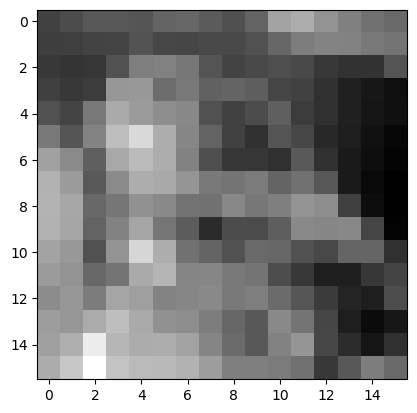

In [33]:
plt.imshow(to_numpy(sample_image_set(cifar_small, 1, 4))[0, 0, 0], cmap='gray')

In [34]:
# model = SimpleCNN().to(device)
# b = 128
# n = 128
# e = 4
# images = sample_images(b, n)
# temp_images = images.reshape(-1, 1, 16, 16)
# embeddings = model(temp_images)
# embeddings = embeddings.reshape(b, n, -1)
# true_f_xquery = embeddings
# print(embeddings.shape)
# print(true_f_xquery.shape)

In [35]:
# images = torch.as_tensor(images).float()
# f_xquery = large_transformer(images, embeddings)
# print(f_xquery.shape)

In [36]:
# loss = F.mse_loss(f_xquery, true_f_xquery)
# print(loss)
# optim.zero_grad()
# loss.backward()
# optim.step()

In [ ]:
total_updates = 500000
b = 128
d = 2
n = d * 8 + 1 # might need to lower this back to 64 for colab
e = 1
lr = 1e-5
last_i = 0
image_size = 8
weighting = ((2 * torch.arange(n).to(device) + 1) / n) ** 2

losses = []
final_losses = []
first_losses = []
all_models = [SimpleCNN(image_size).to(device) for _ in range(e)]
models = random.sample(all_models, e)
large_transformer = VisionICLTransformer(image_size=image_size, patch_size=2).to(device)
optim = torch.optim.AdamW(large_transformer.parameters(), lr)
for i in range(1, total_updates + 1):
    anneal_lr(optim, lr, i, total_updates)
    if i % 50 == 0:
        print(f'epoch: {i}, {losses[-1]}, {final_losses[-1]}, {first_losses[-1]}')
    if len(final_losses) > 10 and np.mean(final_losses[-10:]) < 4 and i - last_i > 10:
        last_i = i
        print(i, 'performance high enough')
        if len(all_models) < b * 2:
            e = min(e * 2, b//2)
            all_models += [SimpleCNN(image_size).to(device) for _ in range(len(all_models))]
            print(f'doubling models to {len(all_models)}, (d={d}, n={n})')
        else:
            if d < image_size:
                e = 4
                all_models = [SimpleCNN(image_size).to(device) for _ in range(e)]
                d += 1
                n = d * 5 + 1
                print(f'increasing difficulty to d={d}, n={n}')
                weighting = ((2 * torch.arange(n).to(device) + 1) / n) ** 2
            else:
                break
    models = random.sample(all_models, e)
    images = sample_image_set(cifar_mini, b, n, d)
    temp_images = images.reshape(-1, 1, image_size, image_size)
    embeddings = ensemble_predict(models, temp_images)
    true_f_xquery= embeddings = embeddings.reshape(b, n, -1)
    f_xquery = large_transformer(images, embeddings)
    loss = (((f_xquery - true_f_xquery) ** 2) * weighting.view(1, -1)).sum(1).mean()
    first_loss = F.mse_loss(f_xquery[:, 0], true_f_xquery[:, 0])
    final_loss = F.mse_loss(f_xquery[:, -1], true_f_xquery[:, -1])
    final_losses.append(final_loss.item())
    losses.append(loss.item())
    first_losses.append(first_loss.item())
    optim.zero_grad()
    loss.backward()
    optim.step()

12 performance high enough
doubling models to 2, (d=2, n=17)


In [ ]:
images = sample_image_set(cifar_mini, b, n+1, d)
testcnn = SimpleCNN(image_size).to(device)
embeddings = testcnn(images.reshape(-1, 1, image_size, image_size))
true_f_xquery= embeddings = embeddings.reshape(b, n+1, -1)
f_xquery = large_transformer(images, embeddings)
F.mse_loss(f_xquery[:, -1], true_f_xquery[:, -1])
print(f_xquery[:, -1])
print(true_f_xquery[:, -1])

tensor([[ 8.0154e-02],
        [ 1.1878e-01],
        [ 8.3330e-02],
        [ 3.8510e-01],
        [ 2.6456e-01],
        [-4.7002e-02],
        [-4.2146e-02],
        [ 6.7189e-02],
        [ 1.7773e-01],
        [-4.1973e-02],
        [-5.2373e-02],
        [ 2.8758e-01],
        [ 4.1514e-01],
        [ 5.8379e-02],
        [ 1.8973e-01],
        [ 2.1448e-01],
        [ 5.5444e-02],
        [ 8.7649e-02],
        [-1.7506e-01],
        [ 1.2606e-01],
        [ 1.3448e-01],
        [ 7.2692e-02],
        [ 6.6069e-02],
        [ 1.5618e-01],
        [ 1.4423e-01],
        [ 1.0529e-01],
        [ 9.5377e-02],
        [-1.7394e-02],
        [ 1.9750e-01],
        [-6.9421e-02],
        [ 3.0620e-01],
        [ 2.3045e-01],
        [ 2.7362e-04],
        [-6.0880e-02],
        [ 2.1332e-01],
        [ 1.2661e-01],
        [ 1.4258e-01],
        [ 1.2737e-01],
        [ 2.9798e-01],
        [ 1.1878e-01],
        [ 6.1643e-02],
        [-1.5376e-01],
        [ 1.2249e-01],
        [ 1

In [ ]:
# total_updates = 50000
# b = 64
# d = 4
# n = d * 2 + 1 # might need to lower this back to 64 for colab
# e = 1
# lr = 4e-4
# last_i = 0
# image_size = 32

# losses = []
# final_losses = []
# all_models = [SimpleCNN(image_size=image_size).to(device) for _ in range(e)]
# models = random.sample(all_models, e)
# large_transformer = VisionICLTransformer(image_size=image_size).to(device)
# optim = torch.optim.AdamW(large_transformer.parameters(), lr)
# for i in range(1, total_updates + 1):
#     anneal_lr(optim, lr, i, total_updates)
#     if i % 50 == 0:
#         print(f'epoch: {i}, {losses[-1]}, {final_losses[-1]}')
#     if len(final_losses) > 10 and np.mean(final_losses[-10:]) < 0.05 and i - last_i > 10:
#         last_i = i
#         print(i, 'performance high enough')
#         if len(all_models) < b * 2:
#             print('doubling models')
#             e = min(e * 2, b//2)
#             all_models += [SimpleCNN(image_size=image_size).to(device) for _ in range(len(all_models))]
#         else:
#             if d < image_size:
#                 all_models = [SimpleCNN(image_size=image_size).to(device)]
#                 e = 1
#                 d += 1
#                 n = d * 3 + 1
#                 print(f'increasing difficulty to d={d}, n={n}')
#             else:
#                 break
#     models = random.sample(all_models, e)
#     images = sample_cifar(b, n, d)
#     temp_images = images.reshape(-1, 1, image_size, image_size)
#     embeddings = ensemble_predict(models, temp_images)
#     true_f_xquery= embeddings = embeddings.reshape(b, n, -1)
#     f_xquery = large_transformer(images, embeddings)
#     loss = F.mse_loss(f_xquery, true_f_xquery)
#     final_loss = F.mse_loss(f_xquery[:, -1], true_f_xquery[:, -1])
#     final_losses.append(final_loss.item())
#     losses.append(loss.item())
#     optim.zero_grad()
#     loss.backward()
#     optim.step()

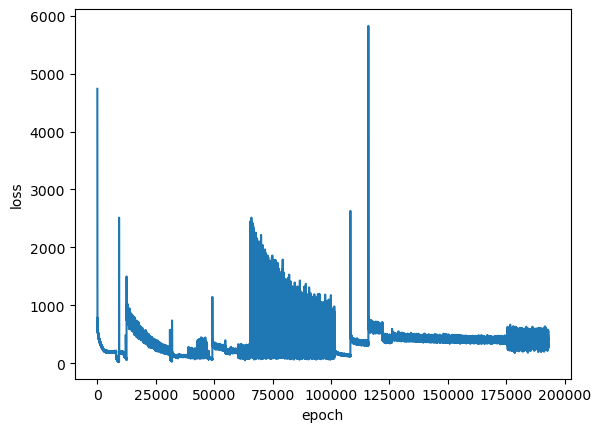

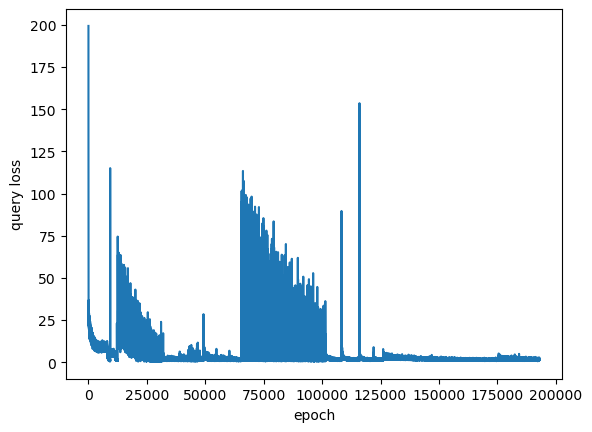

In [ ]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('exp1_loss.png')
plt.show()
plt.plot(final_losses)
plt.xlabel('epoch')
plt.ylabel('query loss')
plt.savefig('exp1_query_loss.png')